In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()

ModuleNotFoundError: No module named 'jupyterthemes'

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.describe()

In [ ]:
df.info()

In [5]:
X = df.drop('SalePrice', axis=1)
y_val = df.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
def get_class(v,bs, max_val=50):
    return v//bs
bin_size = 5e4
y = y_val.apply(lambda value: get_class(value, bin_size, max_val=8e5)).astype(int)

<AxesSubplot:>

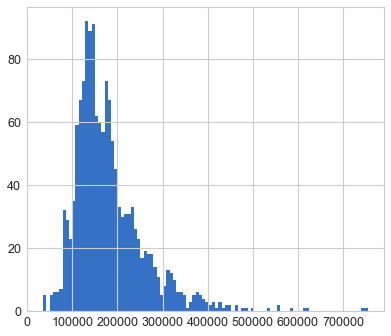

In [7]:
# Целевая переменная - не класс. Сделаем ее классом. Посмотрим, на какие группы разбить 
y_val.hist(bins=100)

<AxesSubplot:>

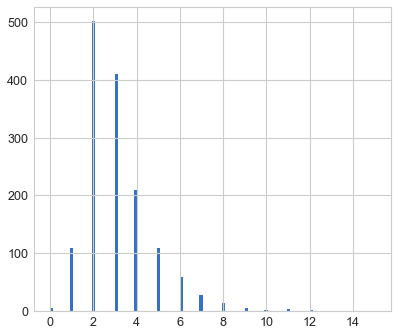

In [8]:
y.hist(bins=100)

In [9]:
#Находим категориальные признаки
cat_feat = list(X.dtypes[X.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
# X[cat_feat] = X[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in X if f not in (cat_feat + ['Id'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = X[cat_feat].nunique()
print(cat_nunique)

# В этом датасете все признаки с менее чем 30ю уникальными значениями, проверку ниже пропустим
# #Чтобы в разы не увеличивать число признаков при построении dummy,
# #будем использовать категориальные признаки с < 30 уникальных значений
# cat_feat = list(cat_nunique[cat_nunique < 30].index) # 

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64


In [10]:
# Создаем дамми-переменные для категорий
X_dummies = pd.get_dummies(X[cat_feat], columns=cat_feat)
# dummy_test = pd.get_dummies(X_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(X_dummies))

X_dummies = X_dummies[dummy_cols]
# dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X = pd.concat([X[num_feat].fillna(-999),
                     X_dummies], axis=1)

# X_test = pd.concat([d_test[num_feat].fillna(-999),
#                      dummy_test], axis=1)

In [11]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior1st_VinylSd,CentralAir_Y,Exterior2nd_CBlock,ExterQual_Ex,SaleCondition_Family,LandSlope_Gtl,RoofMatl_WdShake,Heating_Wall,HeatingQC_TA,RoofMatl_Membran
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,1,1,0,0,0,1,0,0,0,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,1,0,0,0,1,0,0,0,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,1,1,0,0,0,1,0,0,0,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,1,0,0,0,1,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,1,1,0,0,0,1,0,0,0,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
# просто попробовать - не ДЗ
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
# clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)

In [14]:
from sklearn.metrics import r2_score
r2_score(y_test, clf_tree.predict(X_test))

0.7108010811174539

In [15]:
# Результат у случайного леса чуть хуже
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=15, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)   
r2_score(y_test, clf_rf.predict(X_test))

0.6648535893323764

In [16]:
# Есть неважные признаки. Можно будет отбрасывать, если понадобится ускорение (и для стабильности работы)
imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False)

3      0.222516
15     0.193288
5      0.069609
25     0.068734
11     0.067623
         ...   
166    0.000000
164    0.000000
163    0.000000
162    0.000000
287    0.000000
Length: 288, dtype: float64

In [17]:
# бэггинг ухудшает результат как для деревьев, так и для случайных лесов

bag_clf = BaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(max_depth=15, min_samples_leaf=20), n_jobs=-1)
bag_clf.fit(X_train, y_train)
r2_score(y_test, bag_clf.predict(X_test))

0.6864759384077069

In [18]:
# гораздо лучше у регрессии
lreg_model = LinearRegression()
lreg_model.fit(X_train, y_train)
r2_score(y_test, lreg_model.predict(X_test))

0.8345336264783081

In [19]:
# у логистической регрессии - плохо
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
r2_score(y_test, logreg_model.predict(X_test))

0.5614717328159522

In [20]:
# # SVM
# lin_model = SVC(kernel='linear') 
# lin_model.fit(X_train, y_train)
# r2_score(y_test, lin_model.predict(X_test))

In [38]:
classifier = StackingClassifier(
    [
        ('lr', LogisticRegression()),
        # ('linreg', RidgeClassifier()), # ломает работу
        ('dt', DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)),
        # ('svc', SVC(kernel='poly')), # ломает работу 
        ('rf', RandomForestClassifier(n_estimators=10, max_depth=15, min_samples_leaf=20, max_features=0.5, n_jobs=-1))
    ],
final_estimator = LogisticRegression())

In [39]:
# Результат чуть лучше, чем у отдельного дерева. 
classifier.fit(X_train, y_train)
r2_score(y_test, classifier.predict(X_test))

0.7445860015476577